# Nondimensionalization

In [1]:
# download modsim.py if necessary

from os.path import exists

filename = 'modsim.py'
if not exists(filename):
    from urllib.request import urlretrieve
    # url = 'https://raw.githubusercontent.com/AllenDowney/ModSim/main/'
    url = "https://raw.githubusercontent.com/AllenDowney/ModSimPy/master/"
    local, _ = urlretrieve(url+filename, filename)
    print('Downloaded ' + local)

In [2]:
import numpy
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import modsim

In [3]:
def make_system(beta, gamma):
    init = modsim.State(s=89, i=1, r=0)
    init /= init.sum()

    return modsim.System(
        init=init, t_end=7*14,
        beta=beta, gamma=gamma,
    )

def update_func(t, state, system):
    s, i, r = state.s, state.i, state.r

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return modsim.State(s=s, i=i, r=r)

def run_simulation(system, update_func):
    frame = modsim.TimeFrame(columns=system.init.index)
    frame.loc[0] = system.init
    
    for t in range(0, system.t_end):
        frame.loc[t+1] = update_func(t, frame.loc[t], system)
    
    return frame

def calc_total_infected(results, system):
    s_0 = results.s[0]
    s_end = results.s[system.t_end]
    return s_0 - s_end

def sweep_beta(beta_array, gamma):
    sweep = modsim.SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, update_func)
        sweep[beta] = calc_total_infected(results, system)
    return sweep

def sweep_parameters(beta_array, gamma_array):
    frame = modsim.SweepFrame(columns=gamma_array)
    for gamma in gamma_array:
        frame[gamma] = sweep_beta(beta_array, gamma)
    return frame

In [4]:
beta_array = [0.1, 0.2, 0.3, 0.4, 0.5, 
              0.6, 0.7, 0.8, 0.9, 1.0 , 1.1]
gamma_array = [0.2, 0.4, 0.6, 0.8]
frame = sweep_parameters(beta_array, gamma_array)

In [5]:
frame.head()

,0.2,0.4,0.6,0.8
Parameter,,,,
0.1,0.010756,0.003642,0.002191,0.001567
0.2,0.118984,0.010763,0.005447,0.003644
0.3,0.589095,0.030185,0.010771,0.006526
0.4,0.801339,0.131563,0.020917,0.010780
0.5,0.896577,0.396409,0.046140,0.017640


In [6]:
for gamma in frame.columns:
    column = frame[gamma]
    for beta in column.index:
        metric = column[beta]
        print(beta, gamma, metric)

0.1 0.2 0.010756340768063644
0.2 0.2 0.11898421353185373
0.3 0.2 0.5890954199973404
0.4 0.2 0.8013385277185551
0.5 0.2 0.8965769637207062
0.6 0.2 0.942929291399791
0.7 0.2 0.966299311298026
0.8 0.2 0.9781518959989762
0.9 0.2 0.9840568957948106
1.0 0.2 0.9868823507202488
1.1 0.2 0.988148177093735
0.1 0.4 0.0036416926514175607
0.2 0.4 0.010763463373360094
0.3 0.4 0.030184952469116566
0.4 0.4 0.131562924303259
0.5 0.4 0.3964094037932606
0.6 0.4 0.5979016626615987
0.7 0.4 0.7284704154876106
0.8 0.4 0.8144604459153759
0.9 0.4 0.8722697237137128
1.0 0.4 0.9116692168795855
1.1 0.4 0.9386802509510287
0.1 0.6 0.002190722188881611
0.2 0.6 0.005446688837466351
0.3 0.6 0.010771139974975585
0.4 0.6 0.020916599304195316
0.5 0.6 0.04614035896610047
0.6 0.6 0.13288938996079536
0.7 0.6 0.3118432512847451
0.8 0.6 0.47832565854255393
0.9 0.6 0.605687582114665
1.0 0.6 0.7014254793376209
1.1 0.6 0.7738176405451065
0.1 0.8 0.0015665254038139675
0.2 0.8 0.003643953969662994
0.3 0.8 0.006526163529085194
0.4 0

In [7]:
def plot_sweep_frame(frame):
    for gamma in frame.columns:
        column = frame[gamma]
        for beta in column.index:
            metric = column[beta]
            pyplot.plot(beta/gamma, metric, '.', color='C1')

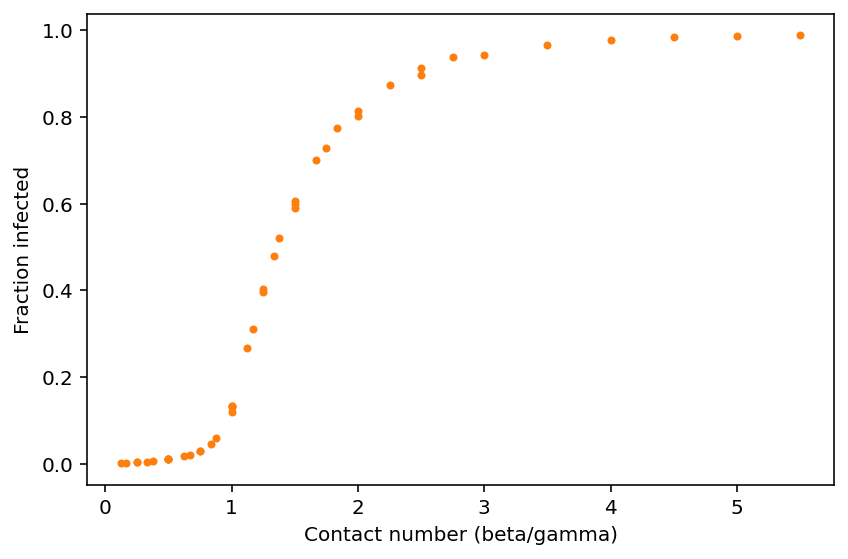

In [8]:
plot_sweep_frame(frame)

modsim.decorate(xlabel='Contact number (beta/gamma)',
         ylabel='Fraction infected')

In [9]:
s_inf_array = numpy.linspace(0.003, 0.99, 50)

In [10]:
c_array = numpy.log(s_inf_array) / (s_inf_array - 1) # DiffEq

In [11]:
frac_infected = 1 - s_inf_array

In [12]:
frac_infected_series = modsim.make_series(c_array, frac_infected)

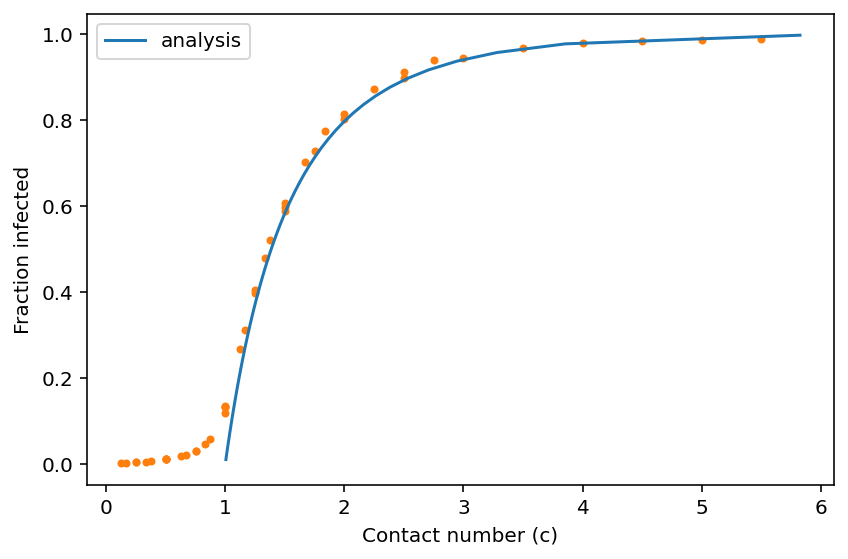

In [13]:
plot_sweep_frame(frame)
frac_infected_series.plot(label='analysis')

modsim.decorate(xlabel='Contact number (c)',
         ylabel='Fraction infected')

### Exercise 1
At the beginning of this chapter, I suggested two ways to relate beta and gamma: we could compute their difference or their ratio.

Because the ratio is dimensionless, I suggested we explore it first, and that led us to discover the contact number, which is `beta/gamma`. When we plotted the fraction infected as a function of the contact number, we found that this metric falls on a single curve, at least approximately. That indicates that the ratio is enough to predict the results; we don’t have to know `beta` and `gamma` individually.

But that leaves a question open: what happens if we do the same thing using the difference instead of the ratio?

Write a version of `plot_sweep_frame`, called `plot_sweep_frame_difference`, that plots the fraction infected versus the difference `beta-gamma`.

What do the results look like, and what does that imply?

In [14]:
def plot_sweep_frame_difference(frame):
    for gamma in frame.columns:
        column = frame[gamma]
        for beta in column.index:
            metric = column[beta]
            pyplot.plot(beta - gamma, metric, '.', color='C1')

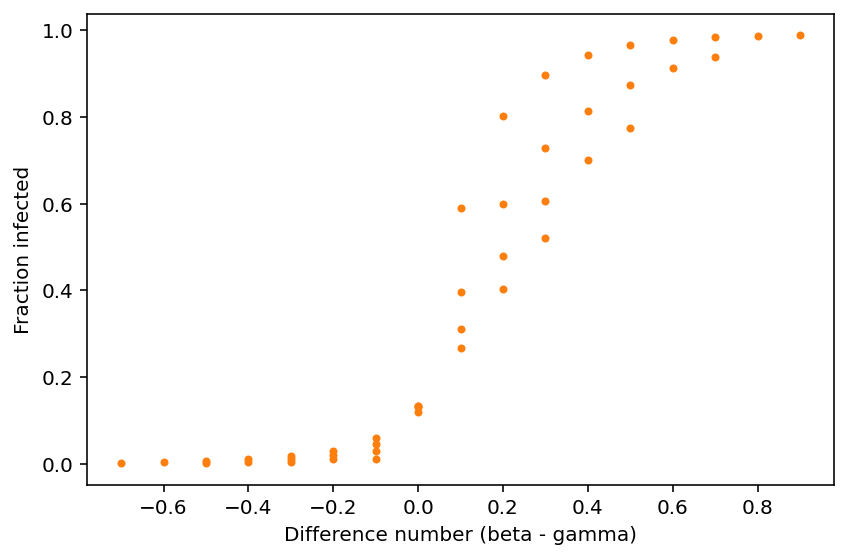

In [15]:
plot_sweep_frame_difference(frame)

modsim.decorate(xlabel='Difference number (beta - gamma)',
         ylabel='Fraction infected')

The results don't fall on a curve, which means that if we  know the difference between `beta` and `gamma`, but not their ratio, that's not enough to predict the fraction infected.

### Exercise 2
Suppose you run a survey at the end of the semester and find that 26% of students had the Freshman Plague at some point. What is your best estimate of `c`?

Hint: if you display `frac_infected_series`, you can read off the answer.

In [16]:
frac_infected_series.tail(15)

index
1.182573    0.292000
1.167003    0.271857
1.151982    0.251714
1.137479    0.231571
1.123464    0.211429
1.109908    0.191286
1.096788    0.171143
1.084080    0.151000
1.071762    0.130857
1.059815    0.110714
1.048220    0.090571
1.036960    0.070429
1.026019    0.050286
1.015381    0.030143
1.005034    0.010000
Name: values, dtype: float64

It looks like the fraction infected is 0.26 when the contact number is about 1.16

### Exercise 3
So far the only metric we have considered is the total fraction of the population that gets infected over the course of an epidemic. That is an important metric, but it is not the only one we care about.

For example, if we have limited resources to deal with infected people, we might also be concerned about the number of people who are sick at the peak of the epidemic, which is the maximum of `I`.

Write a version of `sweep_beta` that computes this metric, and use it to compute a `SweepFrame` for a range of values of `beta` and `gamma`. Make a contour plot that shows the value of this metric as a function of `beta` and `gamma`.

Then use `plot_sweep_frame` to plot the maximum of `I` as a function of the contact number, `beta/gamma`. Do the results fall on a single curve?

In [18]:
def calc_max_infected(results, system):
    return results.i.max()

In [19]:
def sweep_beta(beta_array, gamma):
    sweep = modsim.SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, update_func)
        sweep[beta] = calc_max_infected(results, system)
    return sweep

In [ ]:
def sweep_parameters(beta_array, gamma_array):
    frame = modsim.SweepFrame(columns=gamma_array)
    for gamma in gamma_array:
        frame[gamma] = sweep_beta(beta_array, gamma)
    return frame

In [21]:
frame_2 = sweep_parameters(beta_array, gamma_array)

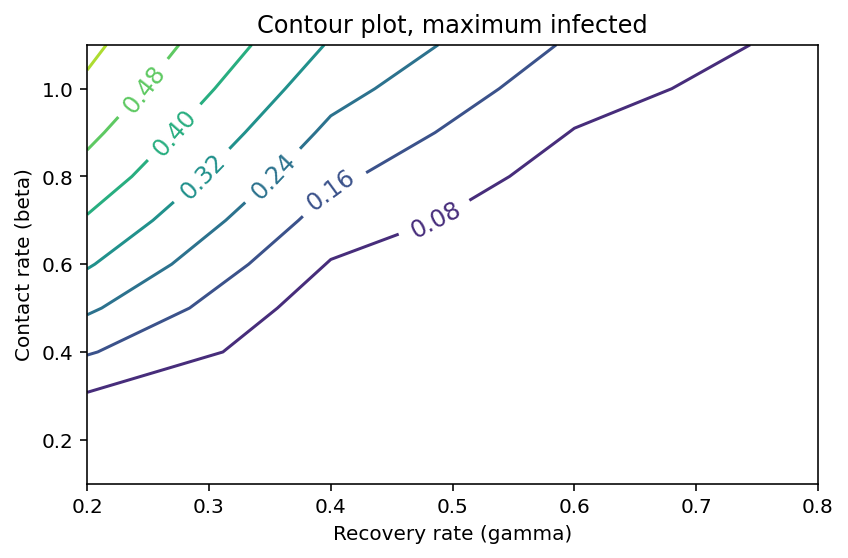

In [23]:
modsim.contour(frame_2)

modsim.decorate(xlabel='Recovery rate (gamma)',
         ylabel='Contact rate (beta)',
         title='Contour plot, maximum infected')

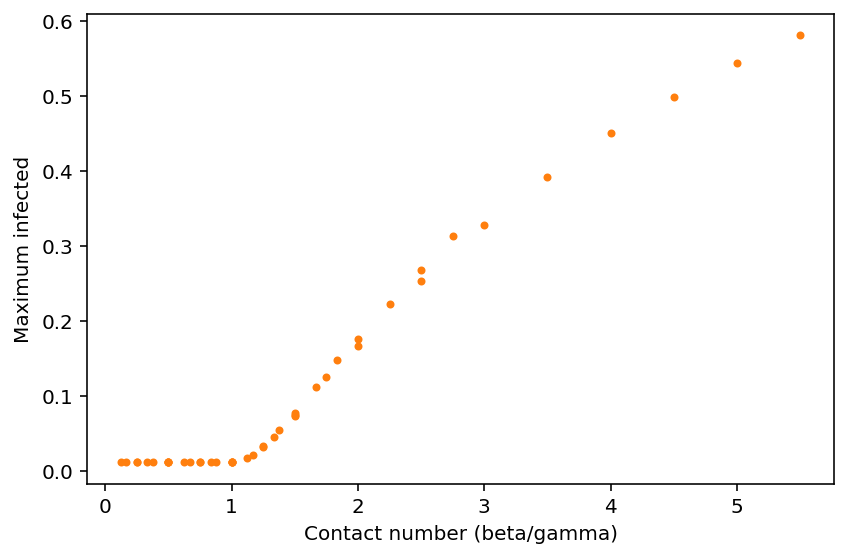

In [25]:
plot_sweep_frame(frame_2)

modsim.decorate(xlabel='Contact number (beta/gamma)',
         ylabel='Maximum infected')